<a href="https://colab.research.google.com/github/jiashenyue/dimensionality-reduction-2/blob/main/feature-engineering-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering for Bike Share Rental Model 

Shenyue Jia | [jiashenyue.info](https://jiashenyue.info)

In this notebook we use the following feature engineering strategies:

1. feature selection
2. removing outliers
3. log transformation
4. changing datatypes
5. scaling
6. binning
7. target encoding

In [132]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

- The functions are from the [Week 10 Lecture 2 Feature Engineering notebook](https://github.com/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Feature%20Engineering%20Code-along.ipynb).

In [133]:
def eval_regression(true, pred, name='Model'):
  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
  scores['MAE'] = [mean_absolute_error(true, pred)]
  scores['R2'] = [r2_score(true, pred)]
  return scores

def eval_classification(true, pred, name='Model'):
  """shows classification_report and confusion matrix
  for the model predictions"""
  
  print(name, '\n')
  print(classification_report(true, pred))
  ConfusionMatrixDisplay.from_predictions(true, pred)
  plt.show()

  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['Precision'] = [precision_score(true, pred)]
  scores['Recall'] = [recall_score(true, pred)]
  scores['F1 Score'] = [f1_score(true, pred)]
  scores['Accuracy'] = [accuracy_score(true, pred)]

  return scores

## Data

We will use the model to predict total number of bike share rentals during a given hour of the day.

Source of data: [this link](https://docs.google.com/spreadsheets/d/e/2PACX-1vROUXPkYUkX-2W7JbJ0-oNKaXzpg4NtmU9IeWEY6yFKm32ZEJOpRh_soHD4BeIcuHjYik3SEoXmkgwj/pub?output=csv)

In [134]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vROUXPkYUkX-2W7JbJ0-oNKaXzpg4NtmU9IeWEY6yFKm32ZEJOpRh_soHD4BeIcuHjYik3SEoXmkgwj/pub?output=csv')
df_backup = df.copy()

display(df.head())
print(df.shape)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


(10886, 12)


## Explore and clean the data
1. Drop the `casual` and `registered` columns as they are redundant to the target variable **`count`**
2. Transform `datetime` column into a datetime type and use it to create 3 new columns
  - Name of the Month
  - Name of the day of the Week
  - Hour of the day
2. Drop any duplicates
3. Look for missing values.  If you want to drop rows or columns, now is the time.  Wait on imputing until after the split.
4. Check summary statistics to look for outliers.

### Drop unnecessary columns

In [135]:
# drop 'Address' column
df.drop(columns=['casual','registered'], inplace=True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,1


### Create hour of the day columns

- Transform datetime column into a datetime type and use it to create 3 new columns
  1. Name of the Month
  2. Name of the day of the Week
  3. Hour of the day
    - Make sure all 3 new columns are 'object' datatype so they can be one-hot encoded later.

- Drop the `datetime` and `season` columns. These are now redundant.

In [136]:
# convert to datetime type
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

In [137]:
# # create new columns
# # code submitted on 02/03/2023
# Month = df['datetime'].dt.strftime('%b').rename('Month')
# DayofWeek = df['datetime'].dt.strftime('%a').rename('DayofWeek')
# HourofDay = df['datetime'].dt.strftime('%H').rename('HourofDay')

# code submitted on 02/04/2023
df['Month'] = df['datetime'].dt.month_name()
df['DayofWeek'] = df['datetime'].dt.day_name()
df['HourofDay'] = df['datetime'].dt.hour.astype(str)

# check if all three variables are in object type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  Month       10886 non-null  object        
 11  DayofWeek   10886 non-null  object        
 12  HourofDay   10886 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory usage: 1.1+ MB


In [138]:
# drop `datetime` column
df.drop(columns=['datetime'], inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay
0,1,0,0,1,9.84,14.395,81,0.0,16,January,Saturday,0
1,1,0,0,1,9.02,13.635,80,0.0,40,January,Saturday,1
2,1,0,0,1,9.02,13.635,80,0.0,32,January,Saturday,2
3,1,0,0,1,9.84,14.395,75,0.0,13,January,Saturday,3
4,1,0,0,1,9.84,14.395,75,0.0,1,January,Saturday,4


### Change `temp` to Fahrenheit

The temperatures in the 'temp' and 'atemp' columns are in Celsius. Use `.apply()` to convert them to Fahrenheit using a Lambda function.

In [139]:
# # apply the equation from Celsius to Fahrenheit
# # using pandas method 02/03/2023
# df['temp'] = df['temp'] * 9/5 + 32
# df['atemp'] = df['atemp'] * 9/5 + 32
# df.head()

In [140]:
# apply the equation from Celsius to Fahrenheit
# using a lambda function 02/04/2023

df['temp'] = df['temp'].apply(lambda x: x * 9/5 + 32)
df['atemp'] = df['atemp'].apply(lambda x: x * 9/5 + 32)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay
0,1,0,0,1,49.712,57.911,81,0.0,16,January,Saturday,0
1,1,0,0,1,48.236,56.543,80,0.0,40,January,Saturday,1
2,1,0,0,1,48.236,56.543,80,0.0,32,January,Saturday,2
3,1,0,0,1,49.712,57.911,75,0.0,13,January,Saturday,3
4,1,0,0,1,49.712,57.911,75,0.0,1,January,Saturday,4


### Create `temp_variance` column

- If `temp` > average, positive
- If `temp` < average, negative

In [141]:
# calculate the difference b/w temp and avg_temp
df['temp_variance'] = df['temp'] - df['atemp']
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Month,DayofWeek,HourofDay,temp_variance
0,1,0,0,1,49.712,57.911,81,0.0,16,January,Saturday,0,-8.199
1,1,0,0,1,48.236,56.543,80,0.0,40,January,Saturday,1,-8.307
2,1,0,0,1,48.236,56.543,80,0.0,32,January,Saturday,2,-8.307
3,1,0,0,1,49.712,57.911,75,0.0,13,January,Saturday,3,-8.199
4,1,0,0,1,49.712,57.911,75,0.0,1,January,Saturday,4,-8.199


In [142]:
# drop atemp column
df.drop(columns=['atemp'], inplace=True)
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,Month,DayofWeek,HourofDay,temp_variance
0,1,0,0,1,49.712,81,0.0,16,January,Saturday,0,-8.199
1,1,0,0,1,48.236,80,0.0,40,January,Saturday,1,-8.307
2,1,0,0,1,48.236,80,0.0,32,January,Saturday,2,-8.307
3,1,0,0,1,49.712,75,0.0,13,January,Saturday,3,-8.199
4,1,0,0,1,49.712,75,0.0,1,January,Saturday,4,-8.199


In [143]:
# check column types to make sure Dtype of newly added columns match 
# the requirement
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         10886 non-null  int64  
 1   holiday        10886 non-null  int64  
 2   workingday     10886 non-null  int64  
 3   weather        10886 non-null  int64  
 4   temp           10886 non-null  float64
 5   humidity       10886 non-null  int64  
 6   windspeed      10886 non-null  float64
 7   count          10886 non-null  int64  
 8   Month          10886 non-null  object 
 9   DayofWeek      10886 non-null  object 
 10  HourofDay      10886 non-null  object 
 11  temp_variance  10886 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 1020.7+ KB


### Check duplicates and missing values

In [144]:
# check for duplicates
if df.duplicated().sum()>0:
  # drop duplicates
  print(f'Removed {df.duplicated().sum()} duplicated rows.')
  df.drop_duplicates()
else:
  print('There is no duplicated rows in the dataframe.')

Removed 1 duplicated rows.


In [145]:
# check for missing values
df.isna().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
humidity         0
windspeed        0
count            0
Month            0
DayofWeek        0
HourofDay        0
temp_variance    0
dtype: int64

In [146]:
# print unique values
cat_cols = ['season', 'holiday', 'workingday', 'weather']
for col in cat_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")

- season:
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64



- holiday:
0    10575
1      311
Name: holiday, dtype: int64



- workingday:
1    7412
0    3474
Name: workingday, dtype: int64



- weather:
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64





- These columns may need to be further engineered to avoid introducing errors to our model

# Feature Engineering

### Categorical Feature Engineering

Based on the unique values contained in each column, these columns should be converted from numeric to categorical type to avoid confusion and errors in the model:

- `season`
- `holiday`
- `workingday`
- `weather`

In [147]:
# convert numeric to categorical
df['season'] = df['season'].astype('object')
df['holiday'] = df['holiday'].astype('object')
df['workingday'] = df['workingday'].astype('object')
df['weather'] = df['weather'].astype('object')

## Datetime Feature Engineering

- Already converted `datetime` column into `Month`, `DayofWeek`, `HourofDay`

## Numeric Feature Engineering

### Filter to remove outliers


 temp 



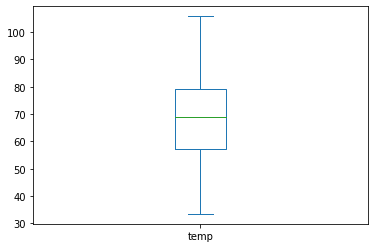


 humidity 



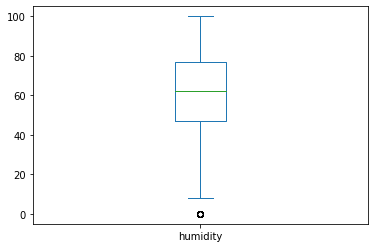


 windspeed 



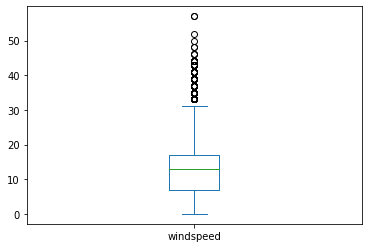


 count 



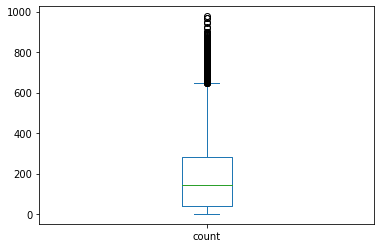


 temp_variance 



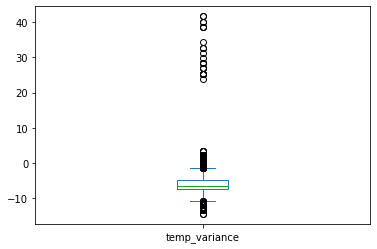

In [148]:
# explore numeric distributions
for col in df.select_dtypes('number'):
  print('\n', col, '\n')
  df[col].plot(kind='box')
  plt.show()

#### `windspeed` column

In [149]:
df['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

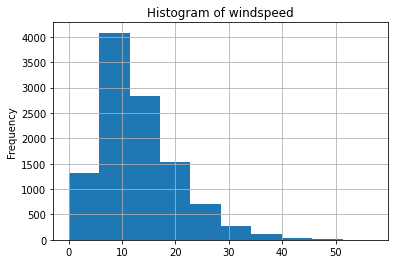

In [150]:
# plot histogram of the original windspeed column
df['windspeed'].plot(kind='hist')
plt.title('Histogram of windspeed')
plt.grid()

In [151]:
# exclude windspeed greater than 40
df = df[df['windspeed'] < 40]
df['windspeed'].describe()

count    10846.000000
mean        12.683501
std          7.949548
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         39.000700
Name: windspeed, dtype: float64

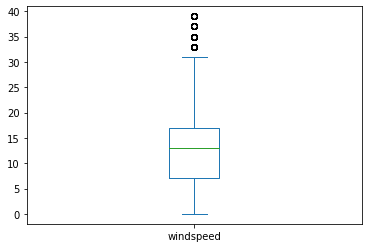

In [152]:
# plot the filtered df
df['windspeed'].plot(kind='box')

#### `temp_variance` column

In [153]:
df['temp_variance'].describe()

count    10846.000000
mean        -6.170107
std          2.809687
min        -14.481000
25%         -7.299000
50%         -6.624000
75%         -5.022000
max         41.652000
Name: temp_variance, dtype: float64

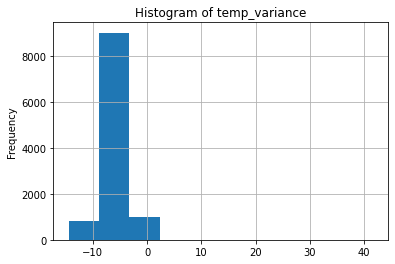

In [154]:
# plot histogram of the original temp_variance column
df['temp_variance'].plot(kind='hist')
plt.title('Histogram of temp_variance')
plt.grid()

In [155]:
# exclude temp_variance greater than 10
df = df[df['temp_variance'] < 10]
df['temp_variance'].describe()

count    10822.000000
mean        -6.253794
std          2.160306
min        -14.481000
25%         -7.299000
50%         -6.624000
75%         -5.022000
max          2.151000
Name: temp_variance, dtype: float64

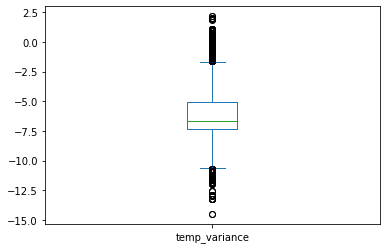

In [156]:
# plot the filtered df
df['temp_variance'].plot(kind='box')

### Transform to normalize feature

- Normalize `temp` and `windspeed` columns
- `humidity` is already a value from 0 to 100% (a relative value); no need to further normalize

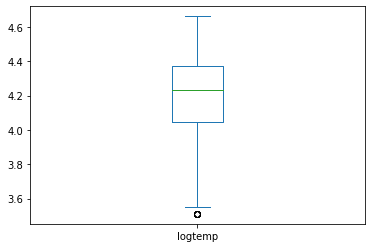

In [157]:
# log transform 'temp'
df['logtemp'] = np.log(df['temp'])
df['logtemp'].plot(kind='box')

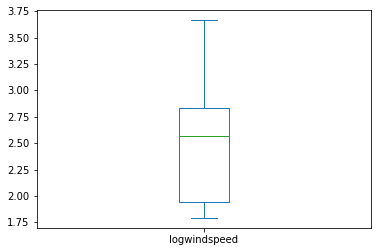

In [158]:
# log transform 'windspeed'
df['logwindspeed'] = np.log(df['windspeed'])
df['logwindspeed'].plot(kind='box')

In [159]:
eng_df = df.copy()
eng_df.drop(columns=['windspeed', 'temp'], inplace=True)

In [160]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10822 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         10822 non-null  object 
 1   holiday        10822 non-null  object 
 2   workingday     10822 non-null  object 
 3   weather        10822 non-null  object 
 4   humidity       10822 non-null  int64  
 5   count          10822 non-null  int64  
 6   Month          10822 non-null  object 
 7   DayofWeek      10822 non-null  object 
 8   HourofDay      10822 non-null  object 
 9   temp_variance  10822 non-null  float64
 10  logtemp        10822 non-null  float64
 11  logwindspeed   10822 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.1+ MB


# Validation Split

In [161]:
X = eng_df.drop(columns=['count'])
y = eng_df['count']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [162]:
X_train.head()

,season,holiday,workingday,weather,humidity,Month,DayofWeek,HourofDay,temp_variance,logtemp,logwindspeed
10104,4,0,1,1,60,November,Tuesday,9,-3.996,3.935505,2.398023
5826,1,0,1,1,72,January,Tuesday,23,-6.957,4.188867,3.258200
10359,4,0,0,1,60,November,Saturday,1,-3.996,3.935505,2.564795
10419,4,0,1,1,54,November,Monday,13,-7.074,4.166231,2.833090
8925,3,0,1,3,83,August,Tuesday,6,-4.590,4.372380,2.564795


# Reference

- This notebook used some code from the following materials
  - [Week 10 Lecture 2 Feature Engineering](https://github.com/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Feature%20Engineering%20Code-along.ipynb)